# Sequentially Comparing Statistical Postprocessing Methods for Weather Forecasts

Following [Henzi and Ziegel (2021)](https://arxiv.org/abs/2103.08402), we compare pairs of [statistical postprocessing](https://arxiv.org/abs/2004.06582) methods for weather forecasts, namely IDR, HCLR, and HCLR_ (HCLR sans a scale parameter).

We use both confidence sequences and e-processes for this analysis.

Code/Data References:
- https://github.com/AlexanderHenzi/eprob/tree/master/replication_material
- https://github.com/AlexanderHenzi/isodistrreg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

import comparecast as cc

In [2]:
DATA_DIR = "eprob/replication_material/precip_fcs"
PLOTS_DIR = "plots/weather"

In [3]:
# Significance level for CS

ALPHA = 0.1  # roughly corresponds to E > 10

In [4]:
cc.set_theme(palette="colorblind")  # change if necessary

## Data & Forecasts

_See [`nb_comparecast_weather_eda.ipynb`](./nb_comparecast_weather_eda.ipynb) for data exploration plots._


- The dataset is collected by Henzi et al. (2019), containing 24-hour accumulated precipitation (mm, integer-rounded) from 2007-01-06 to 2017-01-01 at meteorological stations on airports in London, Brussels, Zurich, and Frankfurt. 
- Covariates (initial forecasts) are the 52 members (1 high-resolution `hres` member, 1 control `ctr` member, and 50 perturbed members that are ensembled `ens`) of the NWP ensemble operated by the European Centre for Medium-Range Weather Forecasts (ECMWF; Molteni et al., 1996; Buizza et al., 2005) for days 1 to 5.
- We compare IDR, HCLR, and HCLR_ as three statistical postprocessing methods for predicting the [probability of precipitation (PoP)](https://www.weather.gov/ffc/pop) given these covariates. Each postprocessing method is fit to the first half of the dataset; we compare their performances on the second half for validation.

## Comparison with Henzi & Ziegel's Results

### Henzi & Ziegel (2021)


Henzi & Ziegel's e-values measure evidence against the null that the score differentials are $\leq 0$ _for all timesteps $i = 1, \dotsc, t$_.

$$
H_0: \mathbb{E}_P[S(p_i, y_i) - S(q_i, y_i) \mid \mathcal{F}_{i-1}] \leq 0 \quad \forall i 
$$

In [5]:
evalues_hz = cc.data_utils.weather.read_hz_evalues(DATA_DIR)
evalues_hz

,Airport,Lag,Date,Precipitation,HCLR,HCLR_,IDR,PoP,Hypothesis,E-value
25,Brussels,1,2012-02-03,0.0,0.071857,0.140121,0.00926,0.0,HCLR/IDR,0.983689
6584,Brussels,1,2012-02-03,0.0,0.071857,0.140121,0.00926,0.0,IDR/HCLR_,1.035356
13143,Brussels,1,2012-02-03,0.0,0.071857,0.140121,0.00926,0.0,HCLR/HCLR_,1.019089
27,Brussels,1,2012-02-04,1.2,0.760288,0.689796,0.61111,1.0,HCLR/IDR,1.037191
6586,Brussels,1,2012-02-04,1.2,0.760288,0.689796,0.61111,1.0,IDR/HCLR_,1.004044
...,...,...,...,...,...,...,...,...,...,...
13113,Zurich,1,2016-12-31,0.0,0.109351,0.168074,0.07071,0.0,IDR/HCLR_,24.998946
19672,Zurich,1,2016-12-31,0.0,0.109351,0.168074,0.07071,0.0,HCLR/HCLR_,60.672551
6558,Zurich,1,2017-01-01,0.0,0.115416,0.175911,0.07920,0.0,HCLR/IDR,0.003016
13117,Zurich,1,2017-01-01,0.0,0.115416,0.175911,0.07920,0.0,IDR/HCLR_,25.691730


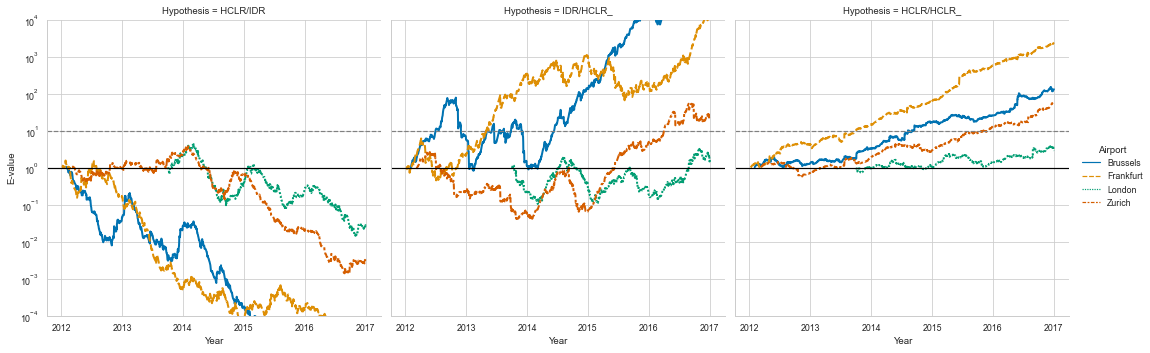

In [6]:
cc.plot_weather_hz_evalues(
    evalues_hz[evalues_hz["Lag"] == 1],
    save_filename=os.path.join(PLOTS_DIR, "evalues_hz_lag1.pdf"),
    use_preset_theme=False,
)

## Ours

Our e-values measure evidence against the null that the _average_ score differentials _up to time $t$_ are 0 or $\leq 0$. This is an example of a "weak null" and would be more difficult to reject than Henzi & Ziegel's "strong null".

$$
H_0 : \frac{1}{t}\sum_{i=1}^t \mathbb{E}_P[S(p_i, y_i) - S(q_i, y_i) \mid \mathcal{F}_{i-1}] \leq 0
$$

We compute both a 90% confidence sequence and a corresponding e-value.

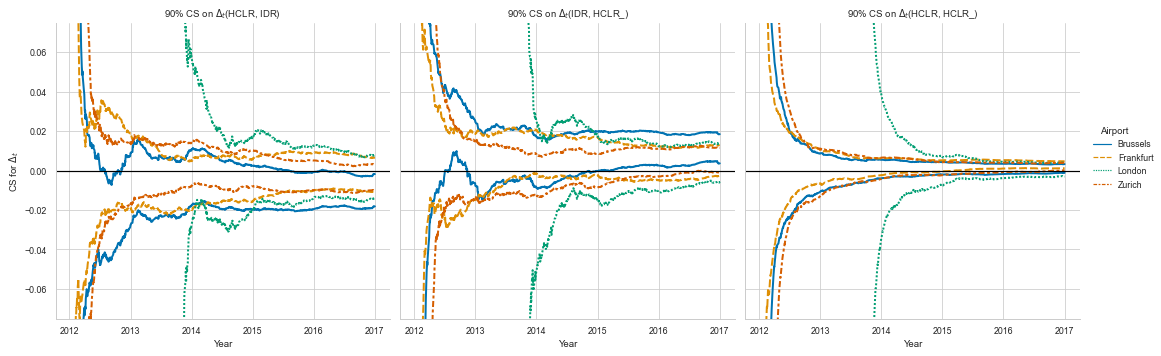

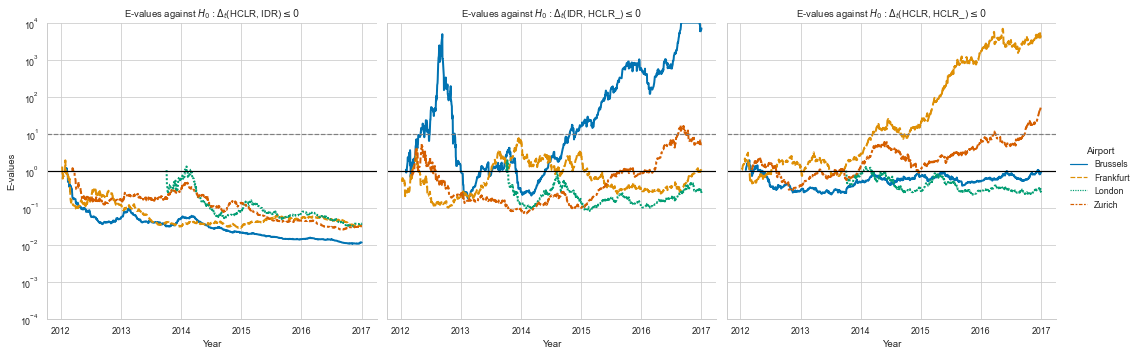

In [7]:
confseqs = cc.plot_weather_comparison(
    data_dir=DATA_DIR,
    lag=1,
    scoring_rule="brier",
    alpha=ALPHA,
    v_opt=0.5,
    c=0.1,
    plots_dir=PLOTS_DIR,
    use_preset_theme=False,
)

## Fixed-Sample Comparisons

Print comparisons in which zero is not included in the CS at the final time step, for all datasets (airports X lags).

In [8]:
from comparecast.data_utils.weather import AIRPORTS, LAGS

pop_fcs = cc.data_utils.weather.read_precip_fcs(DATA_DIR, pop_only=True)

pairs = [("hclr", "idr"), ("idr", "hclr_noscale"), ("hclr", "hclr_noscale")]
print(f"[{100*(1-ALPHA):g}% EB CS at the final time step, decision]")
for airport in AIRPORTS:
    for lag in LAGS:
        pop_fcs_data = pop_fcs[(pop_fcs["airport"] == airport) & 
                               (pop_fcs["lag"] == lag)].copy()
        pop_fcs_data["time"] = np.arange(1, len(pop_fcs_data) + 1)
        for name_p, name_q in pairs:
            lcbs, ucbs, evalues = cc.compare_forecasts(
                pop_fcs_data, 
                name_p, 
                name_q, 
                "brier",
                alpha=ALPHA,
                v_opt=0.5,
                c=0.1,
                compute_evalues=True,
            )
            if lcbs[-1] > 0:
                decision = name_p
            elif ucbs[-1] < 0:
                decision = name_q
            else:
                decision = None
            if decision is not None:
                print(f"{airport:9}/{lag} [T={len(lcbs)}], "
                      f"{name_p:4} vs {name_q:12}: "
                      f"({lcbs[-1]:8.5f}, {ucbs[-1]:8.5f}) \t{decision}")
            
#             if evalues[-1] > 10:
#                 print(f"{airport:9}/{lag} [T={len(lcbs)}], "
#                       f"{name_p:4} vs {name_q:12}: "
#                       f"E {evalues[-1]:7.3f}")

[90% EB CS at the final time step, decision]
Brussels /1 [T=1703], hclr vs idr         : (-0.01818, -0.00181) 	idr
Brussels /1 [T=1703], idr  vs hclr_noscale: ( 0.00362,  0.01842) 	idr
Brussels /5 [T=1703], hclr vs idr         : ( 0.00093,  0.01938) 	hclr
Brussels /5 [T=1703], hclr vs hclr_noscale: ( 0.00033,  0.00554) 	hclr
Frankfurt/1 [T=1809], hclr vs hclr_noscale: ( 0.00115,  0.00469) 	hclr
Frankfurt/2 [T=1809], idr  vs hclr_noscale: ( 0.00086,  0.01468) 	idr
Frankfurt/2 [T=1809], hclr vs hclr_noscale: ( 0.00050,  0.00558) 	hclr
Frankfurt/3 [T=1809], idr  vs hclr_noscale: ( 0.00136,  0.01582) 	idr
Frankfurt/3 [T=1809], hclr vs hclr_noscale: ( 0.00157,  0.00716) 	hclr
Frankfurt/4 [T=1809], hclr vs hclr_noscale: ( 0.00063,  0.00556) 	hclr
Zurich   /1 [T=1621], hclr vs hclr_noscale: ( 0.00017,  0.00397) 	hclr
Zurich   /2 [T=1621], hclr vs hclr_noscale: ( 0.00059,  0.00440) 	hclr
Zurich   /3 [T=1621], hclr vs hclr_noscale: ( 0.00060,  0.00546) 	hclr
Zurich   /5 [T=1621], hclr vs idr   

## Fixed-Sample Comparisons (for $\LaTeX$)

Across all locations and lags.

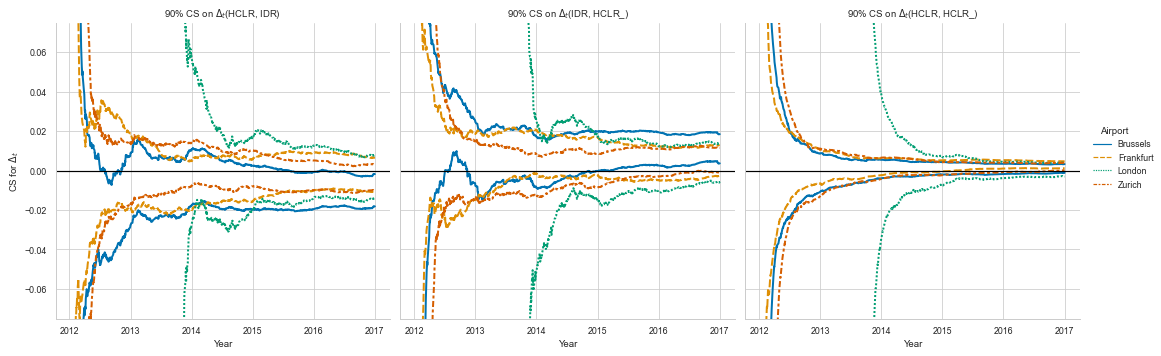

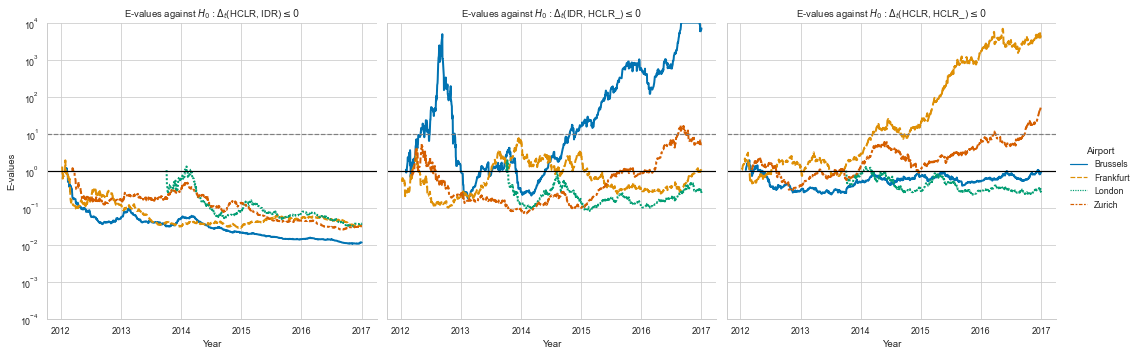

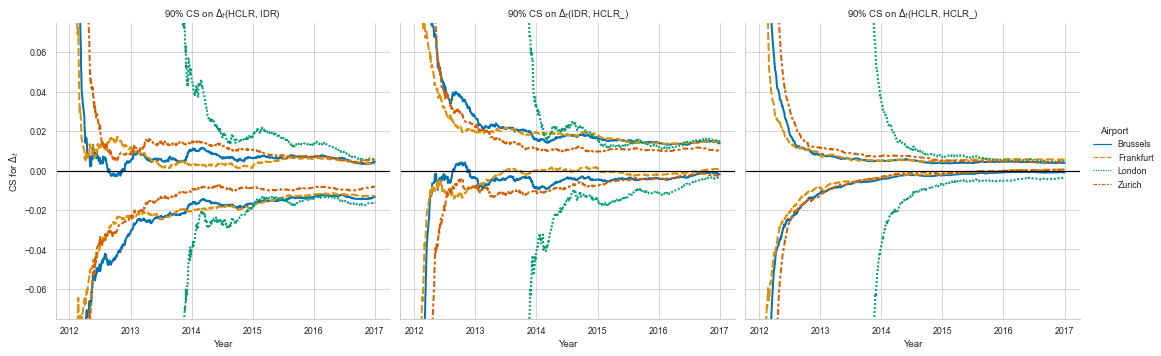

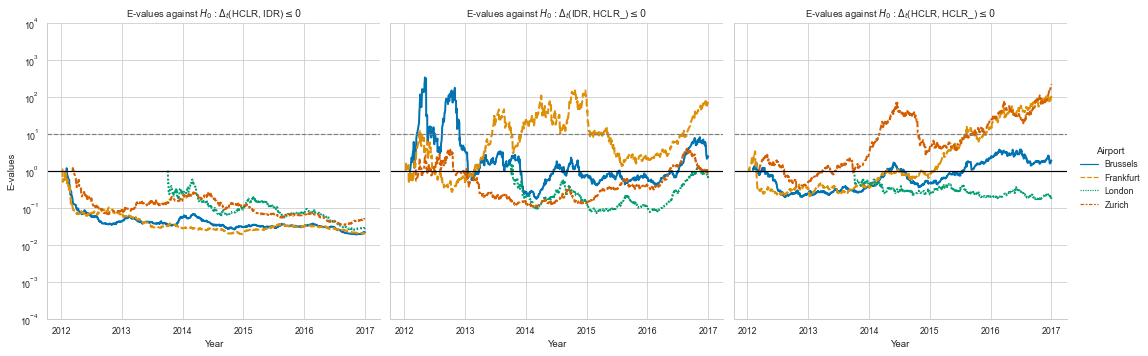

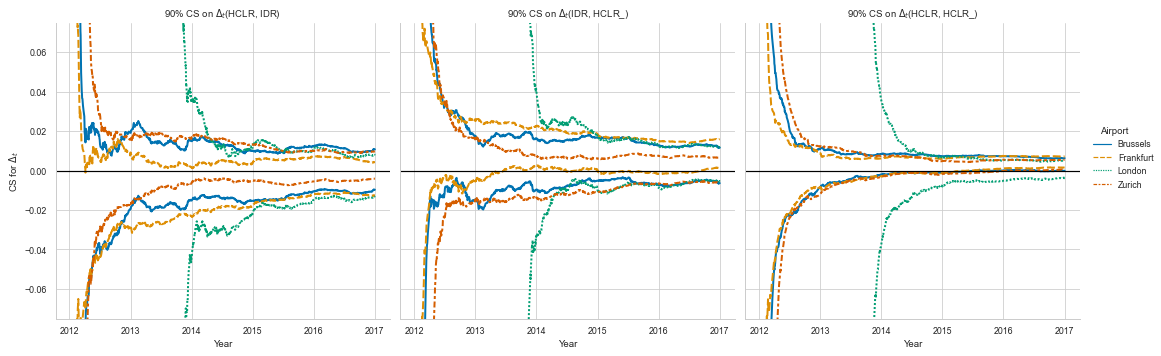

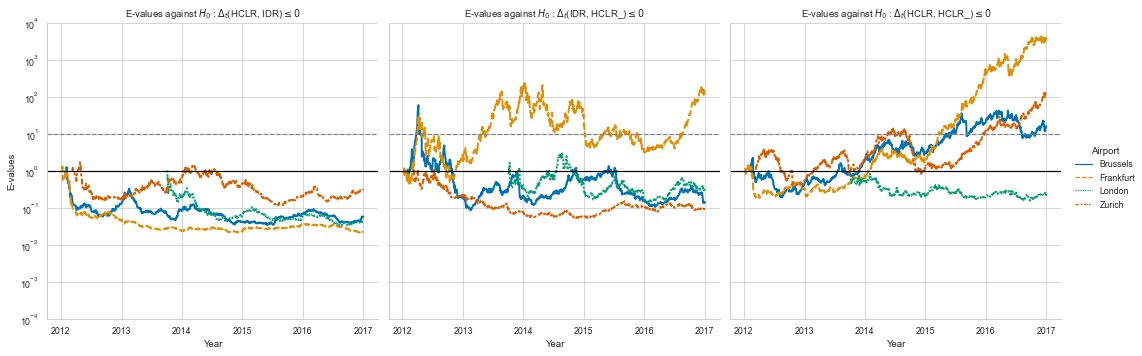

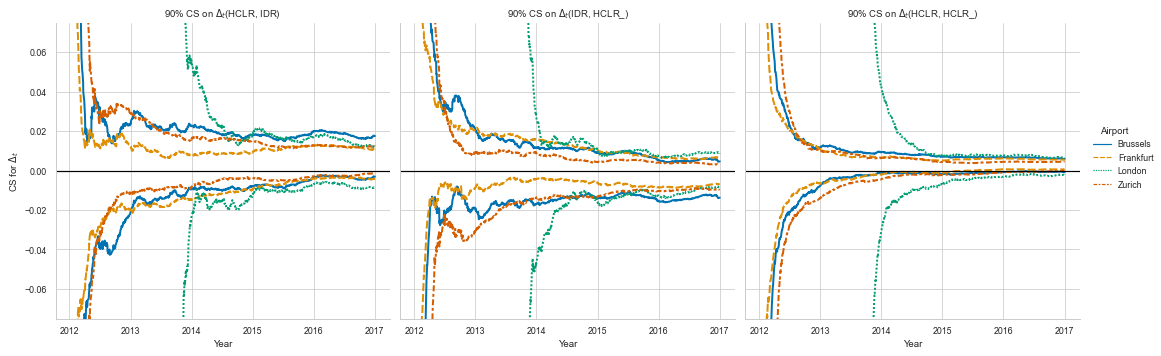

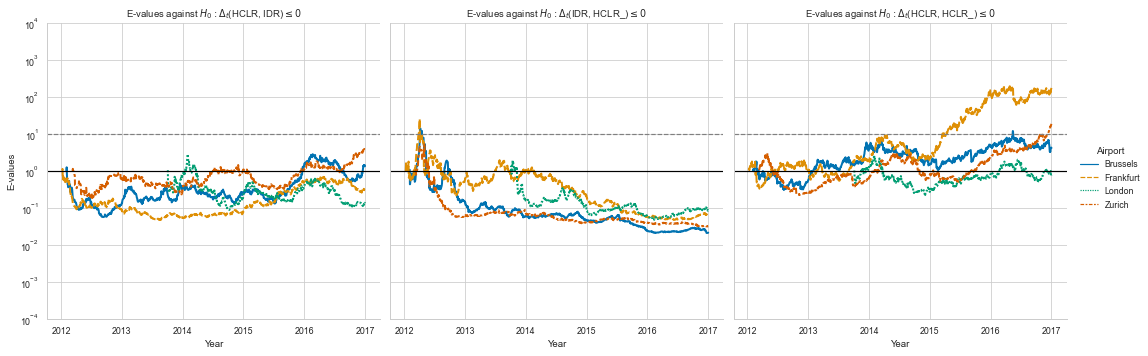

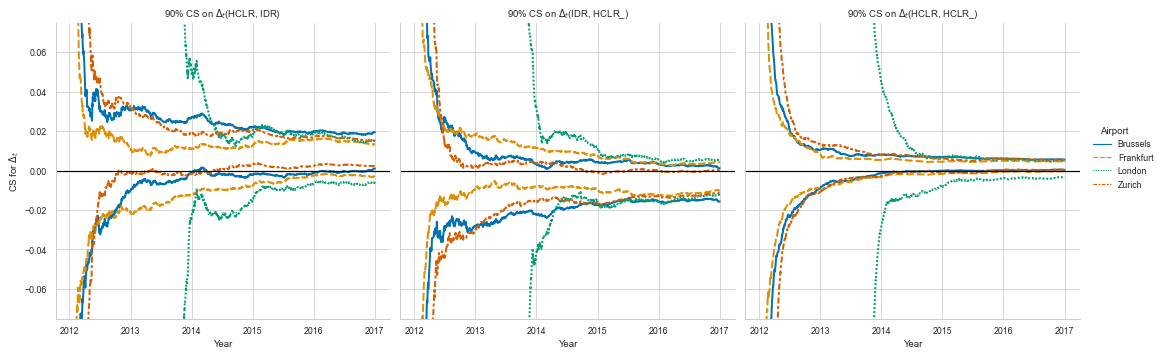

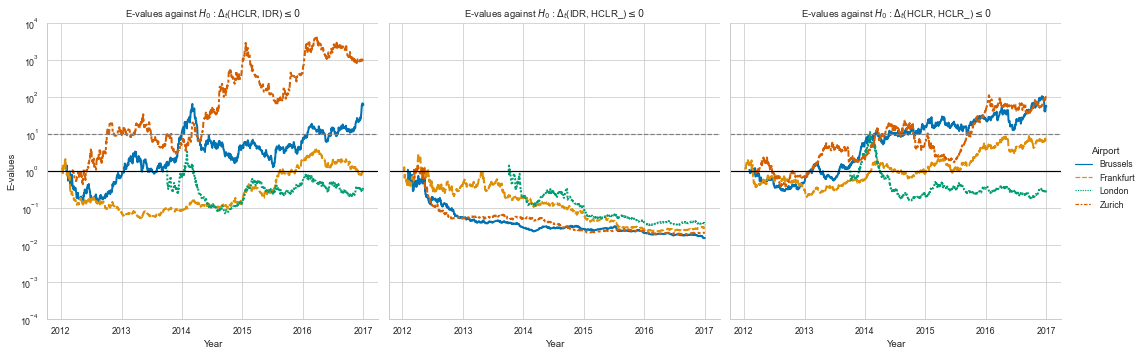

In [9]:
cs_and_evalues = pd.concat([
    cc.plot_weather_comparison(
        data_dir=DATA_DIR,
        lag=lag,
        scoring_rule="brier",
        alpha=ALPHA,
        v_opt=0.5,
        c=0.1,
        plots_dir=PLOTS_DIR,
        use_preset_theme=False,
    )
    for lag in cc.data_utils.weather.LAGS
])

In [10]:
def latex_print(location, lag, hypo1, hypo2, hypo3):
    print("\t{:12s} & {:4s} & {:16s} & {:16s} & {:16s} \\\\".format(
        location, lag, hypo1, hypo2, hypo3
    ))

# last-day comparisons, e-values
latex_print("Location", "Lag", "HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_")
for airport in cc.data_utils.weather.AIRPORTS:
    print("\t\\hline\t\\multirow{{5}}{{*}}{{{}}}".format(airport))
    for lag in cc.data_utils.weather.LAGS:
        df = cs_and_evalues[
            (cs_and_evalues["Airport"] == airport) &
            (cs_and_evalues["Lag"] == lag) &
            (cs_and_evalues["Date"] >= "2017-01-01")
        ]
        evalues = [
            df[(df["Hypothesis"] == hypothesis) & 
               (df["OutputType"] == "E-value")][["Value"]].values.item()
            for hypothesis in ["HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_"]
        ]
        latex_print(
            "", 
            str(lag), 
            *["{:7.3f} & ".format(e) if e <= 100 else r"$>$ 100 & " 
              for e in evalues])

	Location     & Lag  & HCLR/IDR         & IDR/HCLR_        & HCLR/HCLR_       \\
	\hline	\multirow{5}{*}{Brussels}
	             & 1    &   0.011 &        & $>$ 100 &        &   0.915 &        \\
	             & 2    &   0.021 &        &   2.426 &        &   1.871 &        \\
	             & 3    &   0.056 &        &   0.142 &        &  15.606 &        \\
	             & 4    &   1.307 &        &   0.021 &        &   4.078 &        \\
	             & 5    &  58.929 &        &   0.015 &        &  54.825 &        \\
	\hline	\multirow{5}{*}{Frankfurt}
	             & 1    &   0.031 &        &   1.079 &        & $>$ 100 &        \\
	             & 2    &   0.020 &        &  71.817 &        & $>$ 100 &        \\
	             & 3    &   0.021 &        & $>$ 100 &        & $>$ 100 &        \\
	             & 4    &   0.297 &        &   0.065 &        & $>$ 100 &        \\
	             & 5    &   0.829 &        &   0.029 &        &   8.285 &        \\
	\hline	\multirow{5}{*}{London}
	       

In [11]:
# last-day comparisons, CS
latex_print("Location", "Lag", "HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_")
for airport in cc.data_utils.weather.AIRPORTS:
    print("\t\\hline\t\\multirow{{5}}{{*}}{{{}}}".format(airport))
    for lag in cc.data_utils.weather.LAGS:
        df = cs_and_evalues[
            (cs_and_evalues["Airport"] == airport) &
            (cs_and_evalues["Lag"] == lag) &
            (cs_and_evalues["Date"] >= "2017-01-01")
        ]
        lcbs = [
            df[(df["Hypothesis"] == hypothesis) & 
               (df["OutputType"] == "LCB")][["Value"]].values.item()
            for hypothesis in ["HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_"]
        ]
        ucbs = [
            df[(df["Hypothesis"] == hypothesis) & 
               (df["OutputType"] == "UCB")][["Value"]].values.item()
            for hypothesis in ["HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_"]
        ]
        latex_print(
            "", 
            str(lag), 
            *["({:6.3f}, {:6.3f})".format(lcb, ucb)
              for lcb, ucb in zip(lcbs, ucbs)])

	Location     & Lag  & HCLR/IDR         & IDR/HCLR_        & HCLR/HCLR_       \\
	\hline	\multirow{5}{*}{Brussels}
	             & 1    & (-0.018, -0.002) & ( 0.004,  0.018) & (-0.001,  0.003) \\
	             & 2    & (-0.013,  0.004) & (-0.002,  0.014) & (-0.001,  0.004) \\
	             & 3    & (-0.010,  0.011) & (-0.006,  0.012) & (-0.000,  0.006) \\
	             & 4    & (-0.003,  0.017) & (-0.014,  0.005) & (-0.001,  0.006) \\
	             & 5    & ( 0.001,  0.019) & (-0.016,  0.001) & ( 0.000,  0.006) \\
	\hline	\multirow{5}{*}{Frankfurt}
	             & 1    & (-0.011,  0.006) & (-0.003,  0.013) & ( 0.001,  0.005) \\
	             & 2    & (-0.013,  0.003) & ( 0.001,  0.015) & ( 0.001,  0.006) \\
	             & 3    & (-0.013,  0.004) & ( 0.001,  0.016) & ( 0.002,  0.007) \\
	             & 4    & (-0.004,  0.011) & (-0.007,  0.007) & ( 0.001,  0.006) \\
	             & 5    & (-0.003,  0.013) & (-0.010,  0.004) & (-0.000,  0.005) \\
	\hline	\multirow{5}{*}{London}
	       